### Import

In [90]:
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
 
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools as PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

In [91]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)


### DataLoad

In [92]:
# 학습 ChEMBL 데이터 로드
train = pd.read_csv('train.csv')  # 예시 파일 이름
test = pd.read_csv('test.csv')  # 예시 파일 이름
train.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...


### Data Pre-processing

In [93]:
def preprocess_mol(df):
    molecules = df.Smiles.apply(Chem.MolFromSmiles)

    # 분자 리스트로부터 Morgan 지문 비트 벡터 생성
    mols_fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in molecules]


    df.loc[:, 'MolLogP'] = molecules.apply(Descriptors.MolLogP)
    df.loc[:, 'HeavyAtomCount'] = molecules.apply(Descriptors.HeavyAtomCount)
    df.loc[:, 'HAccept'] = molecules.apply(Descriptors.NumHAcceptors)
    df.loc[:, 'Heteroatoms'] = molecules.apply(Descriptors.NumHeteroatoms)
    df.loc[:, 'HDonor'] = molecules.apply(Descriptors.NumHDonors)
    df.loc[:, 'MolWt'] = molecules.apply(Descriptors.MolWt)
    df.loc[:, 'RotableBonds'] = molecules.apply(Descriptors.NumRotatableBonds)
    df.loc[:, 'RingCount'] = molecules.apply(Descriptors.RingCount)
    # df.loc[:, 'Ipc'] = molecules.apply(Descriptors.Ipc)
    df.loc[:, 'HallKierAlpha'] = molecules.apply(Descriptors.HallKierAlpha)
    df.loc[:, 'NumValenceElectrons'] = molecules.apply(Descriptors.NumValenceElectrons)
    # df.loc[:, 'NumSaturatedRings'] = molecules.apply(Descriptors.NumSaturatedRings)
    # df.loc[:, 'NumAliphaticRings'] = molecules.apply(Descriptors.NumAliphaticRings)
    # df.loc[:, 'NumAromaticRings'] = molecules.apply(Descriptors.NumAromaticRings)
    # df.loc[:, 'NHOHCount'] = molecules.apply(Descriptors.NHOHCount)
    # df.loc[:, 'NOCount'] = molecules.apply(Descriptors.NOCount)
    df.loc[:, 'TPSA'] = molecules.apply(Descriptors.TPSA)

    return df



In [94]:
preprocess_mol(train)
preprocess_mol(test)

[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerator
[01:52:11] DEPRECATION WARNING: please use MorganGenerat

,ID,Smiles,MolLogP,HeavyAtomCount,HAccept,Heteroatoms,HDonor,MolWt,RotableBonds,RingCount,HallKierAlpha,NumValenceElectrons,TPSA
0,TEST_000,O=C(C1=CSC(C2=CC=CN=C2)=N1)NC3=CC(NC4CCN(C)CC4...,5.28490,34,7,8,2,477.634,7,5,-2.97,178,79.38
1,TEST_001,N#CC1=CC(C=C2)=C(C=C1)N2C(N=C3)=NC(NC4CCCCC4)=...,4.82478,35,8,8,2,466.593,5,6,-3.70,178,96.38
2,TEST_002,N#CC(C=C1)=C(N[C@@H]2CCNC2)C=C1NC(N=C3)=NC=C3C...,2.26358,31,9,9,4,415.505,6,5,-3.48,158,115.51
3,TEST_003,N#CC(C=C1)=CC=C1NC(N=C2)=NC(NC3CC(NC(C=C)=O)CC...,3.94208,37,9,10,3,498.591,8,5,-4.23,190,129.78
4,TEST_004,N#CC(C=C1)=CC=C1NC(N=C2)=NC(NC3CC(N)CC3)=C2C(C...,3.59858,33,9,9,3,444.543,6,5,-3.48,170,126.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,TEST_108,N#CC1=CC(C=C2)=C(C=C1)N2C(N=C3)=NC(N4CCOCC4)=C...,2.91678,34,9,9,1,454.538,4,6,-3.74,172,96.82
109,TEST_109,O=C(C1=CSC(C2=CC=NC=C2)=N1)NC3=CC(NC4CCN(C(C)C...,4.84700,40,8,10,3,561.756,8,5,-3.50,212,102.49
110,TEST_110,N#Cc1ccc(Nc2ncc(cn2)c3cnn(c3)C4CCNCC4)cc1N[C@@...,2.65368,32,9,9,4,429.532,6,5,-3.48,164,115.51
111,TEST_111,O=C(C)N(CC1)CCC1N2N=CC(C3=CN=C(N4C(C=CC(C#N)=C...,3.33908,31,7,8,0,411.469,3,5,-3.99,154,92.63


In [95]:
#제거 변수

delete = ['Molecule ChEMBL ID','Standard Type','Standard Relation','Standard Value','Standard Units','pChEMBL Value','Assay ChEMBL ID','Target ChEMBL ID','Target Name','Target Organism',
          'Target Type','Document ChEMBL ID','pIC50','IC50_nM']

In [96]:
y_train = train['pIC50']
train = train.drop(delete ,axis=1)

In [97]:
train_smiles_data = train['Smiles']
train_add_features = train.drop(['Smiles'],axis = 1)

In [98]:
test_smiles_data = test['Smiles']
test_add_features = test.drop(['ID','Smiles'],axis = 1)

In [99]:
# 추가 특성 정규화 (선택사항이지만 권장됨)
scaler = StandardScaler()
train_add_features_scaled = scaler.fit_transform(train_add_features)
test_add_features_scaled = scaler.fit_transform(test_add_features)

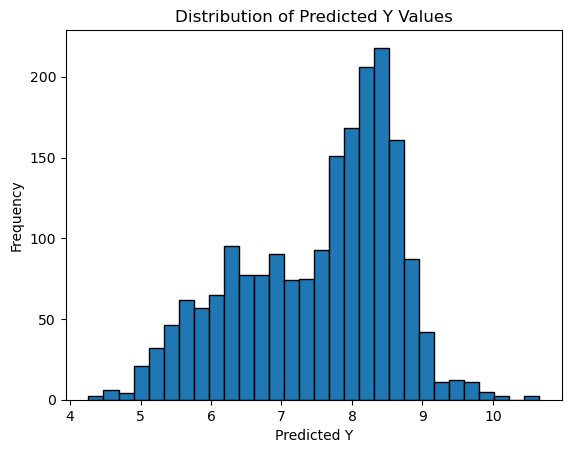

In [100]:
plt.hist(y_train, bins=30, edgecolor='black')
plt.title('Distribution of Predicted Y Values')
plt.xlabel('Predicted Y')
plt.ylabel('Frequency')
plt.show()

### Train & Validation

In [112]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,LSTM,Bidirectional, LSTM,Embedding,Conv1D,GlobalAveragePooling1D,LayerNormalization,BatchNormalization,Input,Concatenate, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.backend import clear_session
import re
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model
import datetime

In [102]:
# # 원자 기호를 추출하는 함수 정의
# def get_atom_tokens(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is not None:
#         atom_tokens = [atom.GetSymbol() for atom in mol.GetAtoms()]
#         return atom_tokens
#     else:
#         return []

# # x_train 데이터프레임에 적용하여 새로운 'AtomTokens' 열 생성
# x_train['Smiles'] = x_train['Smiles'].apply(get_atom_tokens)
# x_val['Smiles'] = x_val['Smiles'].apply(get_atom_tokens)

In [103]:
REGEXPS = {
        "brackets": re.compile(r"(\[[^\]]*\])"),
        "2_ring_nums": re.compile(r"(%\d{2})"),
        "brcl": re.compile(r"(Br|Cl)")
    }
REGEXP_ORDER = ["brackets", "2_ring_nums", "brcl"]

def tokenize(data, with_begin_and_end=True):
    """Tokenizes a SMILES string."""
    def split_by(data, regexps):
        if not regexps:
            return list(data)
        regexp = REGEXPS[regexps[0]]
        splitted = regexp.split(data)
        tokens = []
        for i, split in enumerate(splitted):
            if i % 2 == 0:
                tokens += split_by(split, regexps[1:])
            else:
                tokens.append(split)
        return tokens

    tokens = split_by(data, REGEXP_ORDER)
    
    # if true, the token set is enriched by "^" and "$" denoting the start and end of the embedding, respectively
    if with_begin_and_end:
        tokens = ["^"] + tokens + ["$"]
    return tokens

In [104]:
train_smiles_data = train_smiles_data.apply(tokenize)
test_smiles_data = test_smiles_data.apply(tokenize)

In [105]:
# x_train과 x_val이 이미 정의되어 있다고 가정합니다.
# x_train = x_train['Smiles'].tolist()
# x_val = x_val['Smiles'].tolist()

# Tokenize the SMILES strings
tokenizer = Tokenizer(char_level=True, filters='')
tokenizer.fit_on_texts(train_smiles_data)

# 어휘 사전의 크기 확인
vocab_size = len(tokenizer.word_index) + 1  # +1은 0을 포함시키기 위한 것
print("Vocabulary size:", vocab_size)

# 텍스트를 시퀀스로 변환
train_sequences = tokenizer.texts_to_sequences(train_smiles_data)


# Padding sequences to have the same length (adjust maxlen as necessary)
maxlen = max(len(seq) for seq in train_sequences)
x_train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')

Vocabulary size: 37


In [106]:
x_smiles_train, x_smiles_val, x_features_train, x_features_val, y_train, y_val = train_test_split(x_train_padded, train_add_features_scaled, y_train, test_size=0.2, random_state=98)

In [107]:
embedding_dim = 128
vocab_size = len(tokenizer.word_index) + 1
max_length = x_smiles_train.shape[1]
num_features = x_features_train.shape[1]

In [108]:
print(x_smiles_train.shape)
print(x_smiles_val.shape) 
print(x_features_train.shape) 
print(x_features_val.shape) 

(1561, 119)
(391, 119)
(1561, 11)
(391, 11)


In [113]:
# Early stopping
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.002)

# Learning rate scheduler for cyclical learning rate
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch:
        return lr * 0.9
    return lr

lr_scheduler = LearningRateScheduler(lr_scheduler)

clear_session()

# SMILES 입력
smiles_input = Input(shape=(max_length,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, mask_zero=True)(smiles_input)
x = Bidirectional(LSTM(16, dropout=0.25, recurrent_dropout=0.0, return_sequences=True))(x)
x = Bidirectional(LSTM(16, dropout=0.25, recurrent_dropout=0.0, go_backwards=True, return_sequences=True))(x)
x = GlobalAveragePooling1D()(x)

# 추가 특성 입력
features_input = Input(shape=(num_features,))

# SMILES 처리 결과와 추가 특성 결합
combined = Concatenate()([x, features_input])

# 결합된 특성 처리
x = BatchNormalization()(combined)
x = LayerNormalization()(x)

# Dense layers
x = Dense(8, activation='relu', kernel_regularizer=l1_l2(l1=0.005, l2=0.01))(x)
x = Dense(4, activation='relu', kernel_regularizer=l1_l2(l1=0.005, l2=0.01))(x)

# Output layer
output = Dense(1, activation='linear')(x)

# 모델 정의
model = Model(inputs=[smiles_input, features_input], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

# TensorBoard 설정
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# 모델 그래프 추가
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)


# Model summary
model.summary()

# Model training
history = model.fit([x_smiles_train, x_features_train], y_train,
                    epochs=1000, batch_size=16,
                    validation_data=([x_smiles_val, x_features_val], y_val),
                    callbacks=[es, reduce_lr, lr_scheduler,tensorboard_callback])

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 119)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 119, 128)     4736        ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 119, 32)      18560       ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional

In [114]:
tokenizer.fit_on_texts(test_smiles_data)


test_sequences = tokenizer.texts_to_sequences(test_smiles_data)

# Padding sequences to have the same length (adjust maxlen as necessary)
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')


In [115]:
y_pred = model.predict([test_padded,test_add_features_scaled])

In [116]:
y_pred = pd.DataFrame(y_pred)
y_pred

,0
0,7.028150
1,7.771059
2,6.858967
3,8.324221
4,8.313592
...,...
108,7.569569
109,7.832713
110,7.297829
111,8.373811


In [117]:
y_pred.describe()

,0
count,113.000000
mean,7.737940
std,0.785429
min,5.596522
25%,7.526763
50%,7.810573
75%,8.217213
max,9.562287


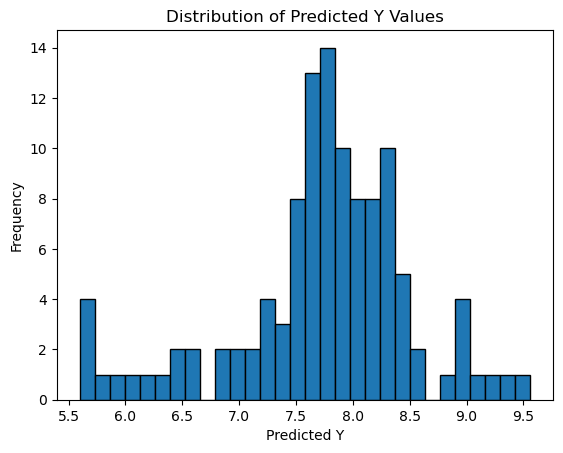

In [118]:
plt.hist(y_pred, bins=30, edgecolor='black')
plt.title('Distribution of Predicted Y Values')
plt.xlabel('Predicted Y')
plt.ylabel('Frequency')
plt.show()

In [119]:
submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(y_pred)
submit.head()

,ID,IC50_nM
0,TEST_000,93.723808
1,TEST_001,16.941074
2,TEST_002,138.367203
3,TEST_003,4.740011
4,TEST_004,4.857447


In [120]:
submit.to_csv('./baseline_submit.csv', index=False)

In [121]:
submit.describe()

,IC50_nM
count,113.000000
mean,145.323517
std,439.413086
min,0.273976
25%,6.064393
50%,15.467741
75%,29.732883
max,2532.084229
